<a href="https://colab.research.google.com/github/pranshumalik14/intuitive-arm-reach/blob/main/notebooks/planar_n_dof_training_datagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

import sys
sys.path.append('../scripts')
sys.path.append('../src')

from robot_arm import RobotArm, RobotArm2D, RobotArm3D
from task_info import TaskInfo, numpy_linspace

# Purpose of notebook
- For a given robot and its respective training data, train an interpolator

# Sections of the notebook
1. Set up the robot object and respecify the task description
1. Load the csv data
1. Train the interpolator
1. Visualize the results

# 1. Set up Robot and task description
This includes number of basis functions (B), the time step (dt), the simulation time (T)

In [8]:
# df = pd.read_csv('../training_data/20220227_1152_pibb_2D.csv')
df = pd.read_csv('../training_data/20220303_1101_pibb_2D.csv')
task_info_df = pd.read_csv('../training_data/20220303_1101_task_info.csv')

In [9]:

def task_info_from_df(df):
    return TaskInfo(
        robotarm = None, #TODO need to fix this
        lambda_min = df["lambda_min"].values[0],
        lambda_max = df["lambda_max"].values[0],
        B = df["B"].values[0],
        K = df["K"].values[0],
        N = df["N"].values[0],
        T = df["T"].values[0],
        h = df["h"].values[0],  # eliteness param
        dt = df["dt"].values[0],
        target_pos = df["target_pos"],
        w = df["w"].values[0],
        cs = df["cs"]
    )

def robot2D_from_df(df):
    return RobotArm2D(df["n_dims"], df["link_lenghts"])

task_info = task_info_from_df(task_info_df)


In [10]:
# robot_arm = RobotArm2D(
#     n_dims      =   2,
#     link_lengths=   np.array([0.6, 0.4])
# )

robot_arm = RobotArm2D(
    n_dims = 3,
    link_lengths = np.array([0.6, 0.3, 0.1])
)

task_info.robotarm = robot_arm

## Data Descriptors
- Init joint angles: Joint configuration at time 0 of robot links
- x_target, y_target: desired target point on the plane for the end effector 
- Theta: output of the PIBB matrix (trained Theta)
- iter_count: (optional) number of iterations it took PIBB to reach to the final Theta
- Cost: (optional) cost function evaluated for this Theta 

Note: 
- this data is only for a specific 2D (planar) robot
- The last two params could be used for the interpolation algorithm (should prefer lower iter_count or cheaper cost)

# 2. Input Data Loading and Cleaning

In [11]:
def str_to_floats(angle_str):
    angle_floats = angle_str[1:len(angle_str)-1].strip().split(" ")
    angle_floats = [angle for angle in angle_floats if angle != ""]
    angle_floats = [float(angle) for angle in angle_floats]
    return angle_floats

In [12]:
# clean task info
target_pos = task_info_df.pop('target_pos')
target_pos_floats = []
for angles in target_pos:
    target_pos_floats.append(str_to_floats(angles))
target_pos_np = np.array(target_pos_floats)

cs = task_info_df.pop('cs')
cs_floats = []
for val in cs:
    cs_floats.append(str_to_floats(val))
cs_vals_np = np.array(cs_floats)

task_info.target_pos = target_pos_np[0]
task_info.cs = cs_vals_np[0]


In [7]:
from sys import platform

delimiter = "\r\n " if platform == "win32" else "\n "

# reshape x target
x_target = df['x_target']
x_target_np = x_target.to_numpy()
x_target = np.reshape(x_target_np, (x_target_np.shape[0], 1))

# rehsape y target
y_target = df['y_target']
y_target_np = y_target.to_numpy()
y_target = np.reshape(x_target_np, (y_target_np.shape[0], 1))

# reshape joint angles

joint_angles = df['init_joint_angles']
joint_angle_floats = []
for angles in joint_angles:
    joint_angle_floats.append(str_to_floats(angles))
joint_angle_np = np.array(joint_angle_floats)
joint_angles = joint_angle_np

# reshape theta

theta = df['Theta']
temp_theta = np.zeros(shape=(len(df), task_info.B, task_info.N)) #670 for each element, 2 for x & y, 5 for gaussian basis functions
for t in range(0, len(temp_theta)):
    if theta[t].startswith("[") and theta[t].endswith("]"):
        temp = theta[t][1:-1]
    else:
        print("Error")
    tp = temp.split(delimiter)
    for i in range(0, len(tp)):
        temp_array = str_to_floats(tp[i])
        temp_theta[t][i] = temp_array
   
theta = temp_theta

print("Input sizes are: \n", "joint angles: ", str(joint_angles.shape), "\nx_target: ",
 str(x_target.shape), "\ny_target: ", str(y_target.shape))
print("Output size is:\n theta: ", str(theta.shape))

Input sizes are: 
 joint angles:  (17, 3) 
x_target:  (17, 1) 
y_target:  (17, 1)
Output size is:
 theta:  (17, 5, 3)


In [8]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

concat_input = np.zeros(shape=(x_target.shape[0], task_info.N + 2)) # joint angles, x_target, y_target
normalize_joint_angles = NormalizeData(joint_angles)
normalize_x_target = NormalizeData(x_target)
normalize_y_target = NormalizeData(y_target)

for i in range(0, len(concat_input)):
    concat_input[i][0] = normalize_joint_angles[i][0]
    concat_input[i][1] = normalize_joint_angles[i][1]
    concat_input[i][2] = normalize_joint_angles[i][2]
    concat_input[i][3] = normalize_x_target[i]
    concat_input[i][4] = normalize_y_target[i]
concat_input = NormalizeData(concat_input)

print(theta.shape)
flatten_theta = np.zeros(shape=(theta.shape[0], theta.shape[1]*theta.shape[2]))
for i in range(0, len(flatten_theta)):
    flatten_theta[i] = theta[i].flatten()

print(concat_input)

(17, 5, 3)
[[0.         0.79328508 1.         1.         1.        ]
 [0.         0.79328508 1.         0.96193977 0.96193977]
 [0.         0.79328508 1.         0.85355339 0.85355339]
 [0.         0.79328508 1.         0.69134172 0.69134172]
 [0.         0.79328508 1.         0.5        0.5       ]
 [0.         0.79328508 1.         0.30865828 0.30865828]
 [0.         0.79328508 1.         0.14644661 0.14644661]
 [0.         0.79328508 1.         0.03806023 0.03806023]
 [0.         0.79328508 1.         0.         0.        ]
 [0.         0.79328508 1.         0.03806023 0.03806023]
 [0.         0.79328508 1.         0.14644661 0.14644661]
 [0.         0.79328508 1.         0.30865828 0.30865828]
 [0.         0.79328508 1.         0.5        0.5       ]
 [0.         0.79328508 1.         0.69134172 0.69134172]
 [0.         0.79328508 1.         0.85355339 0.85355339]
 [0.         0.79328508 1.         0.96193977 0.96193977]
 [0.         0.79328508 1.         1.         1.        ]]


# 3. Model Creation

In [9]:
from rbf_petra.rbflayer import RBFLayer
from rbf_petra.random_initializer import InitCentersRandom
from rbf_petra.kmeans_initializer import InitCentersKMeans

from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import mean_squared_error, cosine_similarity, mean_squared_logarithmic_error
import matplotlib.pyplot as plt 
import datetime

In [10]:
def tune_model_plot(input_data, output_data, num_layers=1, learning_rate=0.001, batch_size=10, initializer = "Random", 
    loss= "cosine_similarity", beta=2.0, validation_split=0.5, optimizer="Adam", epochs=300):
    
    model = Sequential()
    if initializer == "Random":
        tit_init= "rand"
        rbflayer = RBFLayer(10,
                            initializer=InitCentersRandom(input_data),
                            betas=beta,
                            input_shape=(task_info.N + 2,))
    elif initializer == "InitCentersKMeans":
        tit_init="kmeans"
        rbflayer = RBFLayer(batch_size,
                            initializer=InitCentersKMeans(input_data),
                            betas=beta,
                            input_shape=(task_info.N + 2,))
    else:
        print("Wrong initializer")
        return
    model.add(rbflayer)

    if num_layers == 1:
        tit_lay="1"
        pass
    elif num_layers == 2:
        tit_lay="2"
        model.add(Dense(50, activation='relu'))
    elif num_layers == 3:
        tit_lay="3"
        model.add(Dense(70, activation='relu'))
        model.add(Dense(40, activation='relu'))
    elif num_layers == 4:
        tit_lay="4"
        model.add(Dense(80, activation='relu'))
        model.add(Dense(60, activation='relu'))
        model.add(Dense(40, activation='relu'))
    else:
        print("Incorrect num_layers")
        return
    model.add(Dense(task_info.B * task_info.N))
    if optimizer == "Adam":
        tit_opt = "adam"
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "SGD":
        tit_opt = "sgd"
        tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False, name="SGD", **kwargs)
    elif optimizer == "RMSprop":
        tit_opt = "rmsprop"
        tf.keras.optimizers.RMSprop(
            learning_rate=learning_rate,
            rho=0.9,
            momentum=0.0,
            epsilon=1e-07,
            centered=False,
            name="RMSprop",
            **kwargs
        )
    else:
        print("Invalid optimizer")
        return
    if loss == "cosine_similarity":
        tit_loss = "cos_sim"
        model.compile(optimizer=opt, loss=cosine_similarity)
    elif loss == "MSE":
        tit_loss = "mse"
        model.compile(optimizer=opt, loss=mean_squared_error)
    elif loss == "MSElog":
        tit_loss = "mselog"
        model.compile(optimizer=opt, loss=mean_squared_logarithmic_error)
    else:
        print("Invalid loss")
        return
    history = model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=validation_split)

    w = 5
    h = 5
    d = 70
    fig = plt.figure(figsize=(w, h), dpi=d)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    txt = "num_layers=," + str(num_layers) + ", learning_rate=" + str(learning_rate) + ", batch_size=" + str(batch_size) + ", initializer=" + initializer + ",\nloss=" + loss + ", beta=" + str(beta) + ", validation_split=" + str(validation_split) + ", optimizer" + optimizer + ", epochs=" + str(epochs)

    fig_title = tit_init + "_" + str(epochs) + "_" + tit_lay + "_" + tit_loss + "_" + tit_opt
    plt.tight_layout()
    # text(0, 0, txt, ha='left', wrap=True)
    dt = datetime.datetime.today()
    title = str(dt.year) + "/" + str(dt.month) + "/" + str(dt.day) + " RBFPetra Implementation"
    # plt.title(title)
    plt.suptitle(title + "\n" + txt, fontsize=10, y=1.1)
    # plt.show()
    # TODO: savefig throws an error
    # fig.savefig('./parameter_tune_plots/' + fig_title + '.png', bbox_inches='tight')

    return model


2022-03-03 11:05:05.428626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


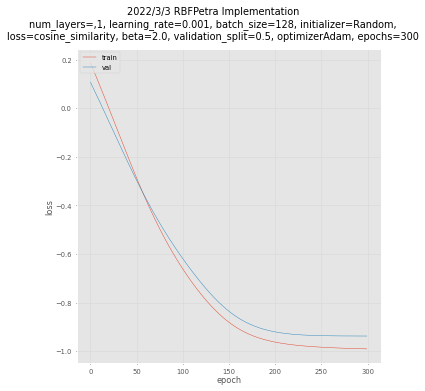

In [11]:
model = tune_model_plot(input_data=concat_input, output_data=flatten_theta, batch_size=128)

## Train Model

In [ ]:
# import matplotlib.pyplot as plt 
# history = model.fit(concat_input, flatten_theta, batch_size=64, epochs=2000, verbose=0, validation_split=0.5)
# # list all data in history
# # # summarize history for accuracy
# # plt.plot(history.history['accuracy'])
# # plt.plot(history.history['val_accuracy'])
# # plt.title('model accuracy')
# # plt.ylabel('accuracy')
# # plt.xlabel('epoch')
# # plt.legend(['train', 'test'], loc='upper left')
# # plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# # print(history.history['loss'])
# plt.plot(history.history['val_loss'])
# # plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# print(history.history['loss'][-1])


Trial Point

In [16]:
target_pt = [1.0, 0.0]
init_condit = [[ -2.47502883,  0.8474106,   1.71317476], [0,0,0]]

In [14]:
to_predict = np.array([init_condit[0][0], init_condit[0][1], init_condit[0][2], target_pt[0], target_pt[1]])
to_predict.shape 
to_predict = np.reshape(to_predict, (1, task_info.N + 2))
to_predict.shape 


(1, 5)

In [15]:
# model.save("model1")
theta_predict = model.predict(to_predict)

In [ ]:
# model = keras.models.load_model("model1")
theta_predict = model.predict(to_predict)

In [16]:
print(theta_predict.shape)

(1, 15)


In [17]:
theta_reshaped = np.reshape(theta_predict, ( task_info.B, task_info.N))
print(theta_predict)
print(theta_reshaped)

[[ 1.52200028e-01  1.18518826e-02 -1.89268857e-01  8.31558630e-02 -1.63754255e-01  1.49079844e-01  1.58179596e-01 -1.02821484e-01 -2.32775092e-01  6.29935603e-05  1.29810095e-01  8.85419268e-03  1.01595573e-01 -2.19810069e-01  6.15377650e-02]]
[[ 1.52200028e-01  1.18518826e-02 -1.89268857e-01]
 [ 8.31558630e-02 -1.63754255e-01  1.49079844e-01]
 [ 1.58179596e-01 -1.02821484e-01 -2.32775092e-01]
 [ 6.29935603e-05  1.29810095e-01  8.85419268e-03]
 [ 1.01595573e-01 -2.19810069e-01  6.15377650e-02]]


In [ ]:
from pdff_kinematic_sim_funcs import PIBB

B = 5
K = 20
N = 3

# target_pt = np.array([0.45962666587138673, -0.3856725658119237])
# init_condit = [np.array([-0.22773365,  2.30641929, -2.39580577]), np.array([0, 0, 0])]
robot_arm = RobotArm2D(
    n_dims = N,
    link_lengths = np.array([0.6, 0.3, 0.1])
)
lambda_init = lambda_min = 0.05; lambda_max = 5; 
Sigma_matrix = np.array( [lambda_init*np.eye(B) for i in range(N)] )

# Shape should be B * B * N but we have N * B * B -> indexing has to change accordingly
Theta_matrix = np.zeros(B*N).reshape((B,N));               # no default action to start with

task_info = TaskInfo(
    robotarm = robot_arm,
    lambda_min = lambda_min,
    lambda_max = lambda_max,
    B = B,
    K = K,
    N = N,
    T = 1,
    h = 10,
    target_pos = target_pt,
    dt = 1e-2
)
Theta, iter_count, J_hist = PIBB(task_info, Theta_matrix, Sigma_matrix, init_condit)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(iter_count+1), J_hist)

In [ ]:
Theta

In [ ]:
from pdff_kinematic_sim_funcs import gen_theta

theta, _, _, _ = gen_theta(
    x_target = target_pt,
    init_condit = init_condit,
    robot_arm = robot_arm,
    B = 5
)

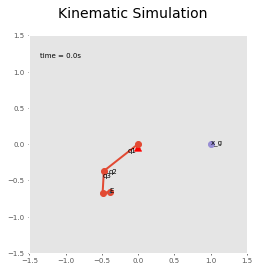

In [18]:

Theta = np.array(
    [
[ 24.62965263,  -4.66998815, -11.90077967],
 [ 18.68746022,   1.69772392 ,  5.17956646],
  [ 14.5241227 ,   1.83870319,  -3.89498501],
  [  1.50572703,  -0.05676084,  -4.69705758],
  [  1.54520611,  -0.88447168,   5.45709876]
        ]
)

# Theta = np.array(
#     [
#         [  6.01261745,  -4.4867893,  -11.65465108],
#          [  6.8173749,   -0.2636031,    5.31197516],
#           [  6.75830598,  -0.17467107,  -3.2228001 ],
#            [ -4.25497469,   0.14448337,  -3.35150551],
#             [  1.29109797,  -1.87628796,   3.92199235]
#     ]
# )


gen_qdotdot = np.array(  [qdotdot_gen(task_info, Theta, t)
                        for t in numpy_linspace(0, 1, 1e-2)]  )
time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
    gen_qdotdot, robot_arm, target_pt, init_condit = init_condit, dt = 0.01)
plt.show()
from IPython import display
video = ani.to_jshtml(fps = 60)
# video = ani.to_html5_video() # to save as mp4, use this
html = display.HTML(video)
display.display(html)

# Visualization of theta

In [14]:
from PIBB_helper import qdotdot_gen
from pdff_kinematic_sim_funcs import get_traj_and_simulate2d, get_traj
import matplotlib.pyplot as plt

predicted_qdotdot = np.array(  
    [
        qdotdot_gen(task_info, theta_reshaped, t) for t in numpy_linspace(0, task_info.T, task_info.dt)
    ]  
    )
    
# print(predicted_qdotdot.shape)
time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
    qdotdot     = predicted_qdotdot, 
    robot_arm   = robot_arm, 
    x_goal      = target_pt, 
    init_condit = init_condit, 
    dt          = task_info.dt
    )

NameError: name 'theta_reshaped' is not defined

In [19]:
from IPython import display
video = ani.to_jshtml(fps = 60)
# video = ani.to_html5_video() # to save as mp4, use this
html = display.HTML(video)
display.display(html)

## Model V2

In [ ]:
import tensorflow as tf

In [ ]:
# https://www.tensorflow.org/addons/tutorials/losses_triplet
